In [ ]:
!pip install nltk

In [ ]:
!pip install tensorflow --upgrade --no-cache-dir
!pip install tensorflow-addons --upgrade --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 137.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 61.3 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully 

## **Training 603 Data**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Found NaN values in labels. Dropping rows with NaN values.


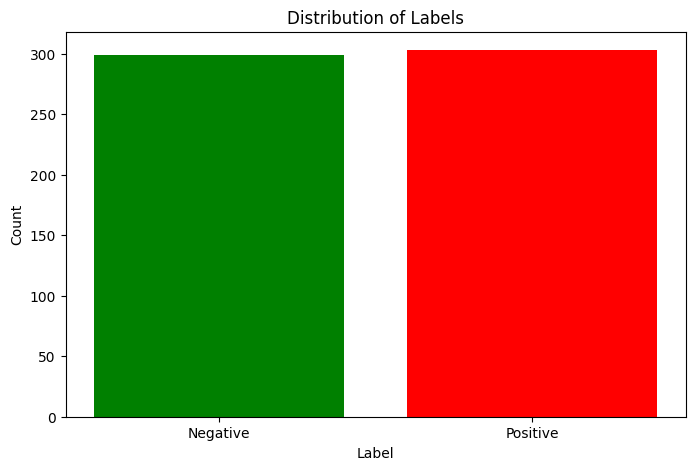

Label counts:
Label
1.0    303
0.0    299
Name: count, dtype: int64


In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/Dataset Analisis Sentimen.xlsx'
df = pd.read_excel(file_path)

# Data Preprocessing
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

def preprocess_text(text):
    text = str(text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['cleaned_text'] = df['Komentar'].apply(preprocess_text)

# Convert labels to numeric values
df['Label'] = df['Label'].map({'Negative': 0, 'Positive': 1})

# Check for NaN values in labels and handle them
if df['Label'].isnull().any():
    print("Found NaN values in labels. Dropping rows with NaN values.")
    df = df.dropna(subset=['Label'])

# Ensure labels are of type float32
df['Label'] = df['Label'].astype(float)

# Plotting the distribution of labels
label_counts = df['Label'].value_counts()
plt.figure(figsize=(8, 5))
plt.bar(label_counts.index, label_counts.values, color=['red', 'green'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

# Print the number of each label
print("Label counts:")
print(label_counts)

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import tensorflow as tf
import numpy as np

# Load the dataset
file_path = '/content/Dataset Analisis Sentimen.xlsx'
df = pd.read_excel(file_path)

# Data Preprocessing
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

def preprocess_text(text):
    text = str(text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['cleaned_text'] = df['Komentar'].apply(preprocess_text)

# Convert labels to numeric values
df['Label'] = df['Label'].map({'Negative': 0, 'Positive': 1})

# Check for NaN values in labels and handle them
if df['Label'].isnull().any():
    print("Found NaN values in labels. Dropping rows with NaN values.")
    df = df.dropna(subset=['Label'])

# Ensure labels are of type float32
df['Label'] = df['Label'].astype(np.float32)

# Tokenization and Padding
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

X = pad_sequences(sequences, maxlen=max_len)
y = df['Label'].values

# Ensure all data is numeric and of type float32
X = X.astype(np.float32)
y = y.astype(np.float32)

# Check for NaN or infinite values
if np.isnan(X).any() or np.isinf(X).any():
    raise ValueError("X contains NaN or infinite values")
if np.isnan(y).any() or np.isinf(y).any():
    raise ValueError("y contains NaN or infinite values")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define custom F1 Score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Initialize custom F1Score metric
f1_score_metric = F1Score()

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with built-in Precision, Recall, and the custom F1 Score
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        f1_score_metric
    ]
)

# Display the model summary
model.build(input_shape=(None, max_len))
model.summary()

# Train the model with additional debugging information
try:
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)
except Exception as e:
    print(f"Error during training: {e}")

# Evaluate the model on the test set
try:
    loss, accuracy, precision, recall, f1_score = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {accuracy}')
    print(f'Test Precision: {precision}')
    print(f'Test Recall: {recall}')
    print(f'Test F1 Score: {f1_score}')
except Exception as e:
    print(f"Error during evaluation: {e}")

# Save the metrics to a file
metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1_score,
    'loss': loss
}

np.save('model_metrics.npy', metrics)

# Save the training history
np.save('training_history.npy', history.history)

Found NaN values in labels. Dropping rows with NaN values.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 100, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,543,297 (5.89 MB)

 Trainable params: 1,543,297 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 598ms/step - accuracy: 0.4751 - f1_score: 0.2966 - loss: 0.6932 - precision_5: 0.4384 - recall_5: 0.2373 - val_accuracy: 0.5464 - val_f1_score: 0.6716 - val_loss: 0.6876 - val_precision_5: 0.5056 - val_recall_5: 1.0000
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 377ms/step - accuracy: 0.6381 - f1_score: 0.7289 - loss: 0.6706 - precision_5: 0.5863 - recall_5: 0.9677 - val_accuracy: 0.6907 - val_f1_score: 0.7222 - val_loss: 0.5991 - val_precision_5: 0.6190 - val_recall_5: 0.8667
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 543ms/step - accuracy: 0.7701 - f1_score: 0.8159 - loss: 0.4939 - precision_5: 0.7283 - recall_5: 0.9295 - val_accuracy: 0.7320 - val_f1_score: 0.7451 - val_loss: 0.4950 - val_precision_5: 0.6667 - val_recall_5: 0.8444
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 384ms/step - accuracy: 0.8862 - f1_score: 0.8953 - loss: 0.3165 - precision_5: 0.8350 - recall_5: 0.9709 - val_accuracy: 0.7526 - val_f1_score: 0.7736 - val_loss: 0.4718 - val_pr

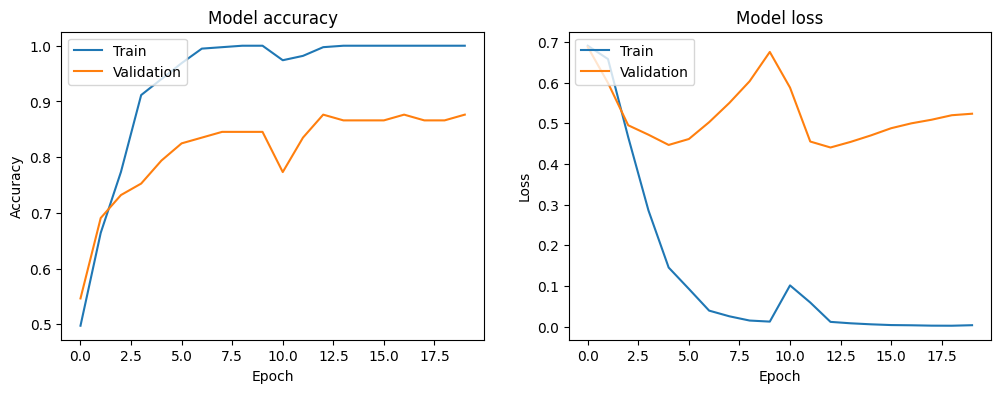

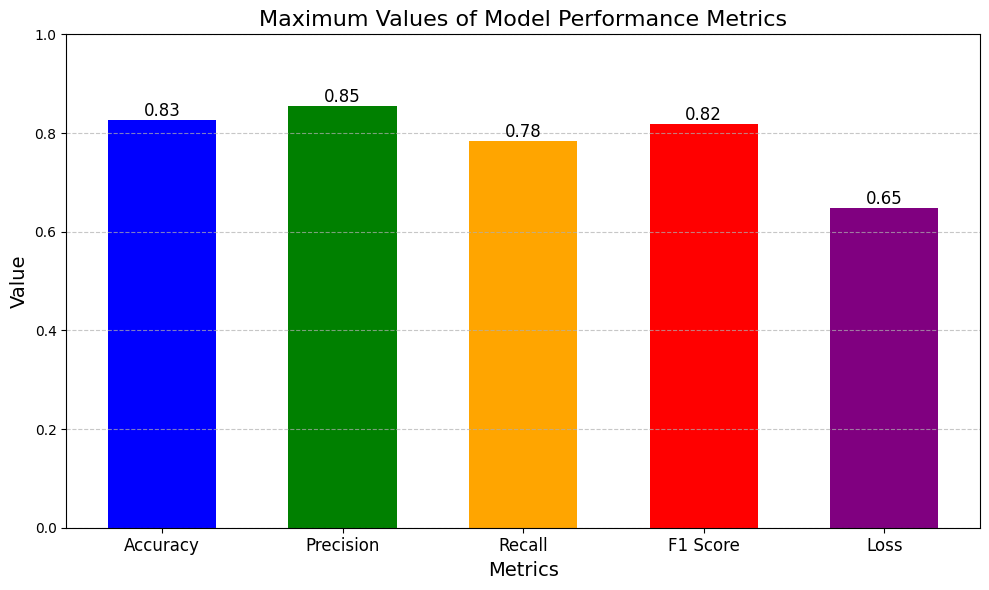

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the metrics
metrics = np.load('model_metrics.npy', allow_pickle=True).item()
history = np.load('training_history.npy', allow_pickle=True).item()

# Plotting the Training History
try:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()
except Exception as e:
    print(f"Error during plotting: {e}")

# Plot the maximum values of model performance metrics
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score", "Loss"]
max_values = [
    metrics['accuracy'],
    metrics['precision'],
    metrics['recall'],
    metrics['f1_score'],
    metrics['loss']
]

# Atur jarak antar bar
x = np.arange(len(metrics_names))  # Posisi x untuk setiap bar
bar_width = 0.6  # Lebar setiap bar

# Plot bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(x, max_values, color=["blue", "green", "orange", "red", "purple"], width=bar_width)

# Tambahkan nilai di atas setiap bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}", ha="center", va="bottom", fontsize=12)

# Tambahkan label dan judul
plt.title("Maximum Values of Model Performance Metrics", fontsize=16)
plt.ylabel("Value", fontsize=14)
plt.xlabel("Metrics", fontsize=14)
plt.xticks(x, metrics_names, fontsize=12)  # Posisi x diganti nama metrik
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim(0, 1)  # Tambahkan ruang di atas bar

# Tampilkan grafik
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Fungsi untuk memproses kalimat uji
def preprocess_text(text):
    # Proses yang sama seperti saat preprocessing data pelatihan
    text = str(text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Hapus karakter selain huruf dan spasi
    text = text.lower()  # Ubah teks menjadi lowercase
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Hapus stopwords
    return ' '.join(words)

# Fungsi untuk membuat vektor kalimat menggunakan tokenizer
def make_sentence_vector(sentence, tokenizer, max_len=100):
    # Preprocessing kalimat
    sentence = preprocess_text(sentence)

    # Ubah kalimat menjadi urutan angka berdasarkan tokenizer
    sequence = tokenizer.texts_to_sequences([sentence])

    # Padding agar panjangnya sesuai dengan max_len
    return pad_sequences(sequence, maxlen=max_len)

# Kalimat uji
test_sentence = "anjirrr lo cok"

# Membuat vektor kalimat uji
test_vec = make_sentence_vector(test_sentence, tokenizer, max_len=100)

# Periksa apakah vektor valid dan dapat diproses
if test_vec.shape[0] > 0:
    # Lakukan prediksi dengan model
    output = model.predict(test_vec)

    # Ambil prediksi yang dihasilkan (model output adalah probabilitas)
    prediction = 1 if output >= 0.5 else 0  # Ambil threshold 0.5 untuk keputusan
    sentiment = "Positive" if prediction == 1 else "Negative"

    print(f"Sentence: \"{test_sentence}\"")
    print(f"Predicted Sentiment: {sentiment}")
else:
    print("The test sentence contains words not in the vocabulary.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
Sentence: "anjirrr lo cok"
Predicted Sentiment: Negative


## **Training 883 Data**

Found NaN values in labels. Dropping rows with NaN values.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


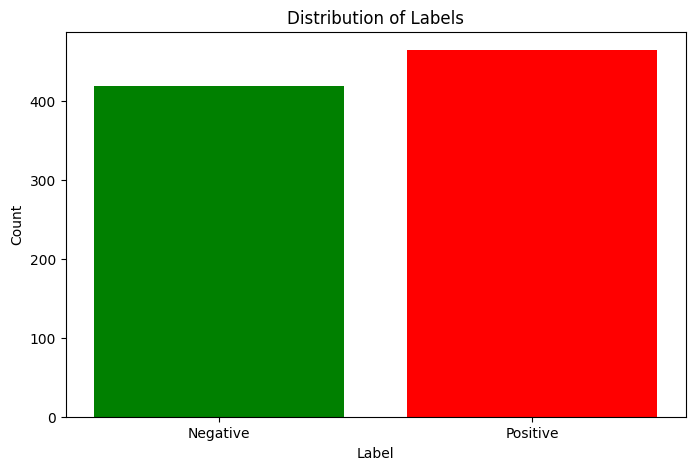

Label counts:
Label
1.0    464
0.0    418
Name: count, dtype: int64


In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/Dataset Analisis Sentimen (1).xlsx'
df = pd.read_excel(file_path)

# Data Preprocessing
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

def preprocess_text(text):
    text = str(text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['cleaned_text'] = df['Komentar'].apply(preprocess_text)

# Convert labels to numeric values
df['Label'] = df['Label'].map({'Negative': 0, 'Positive': 1})

# Check for NaN values in labels and handle them
if df['Label'].isnull().any():
    print("Found NaN values in labels. Dropping rows with NaN values.")
    df = df.dropna(subset=['Label'])

# Ensure labels are of type float32
df['Label'] = df['Label'].astype(float)

# Plotting the distribution of labels
label_counts = df['Label'].value_counts()
plt.figure(figsize=(8, 5))
plt.bar(label_counts.index, label_counts.values, color=['red', 'green'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

# Print the number of each label
print("Label counts:")
print(label_counts)

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import tensorflow as tf
import numpy as np

# Load the dataset
file_path = '/content/Dataset Analisis Sentimen (1).xlsx'
df = pd.read_excel(file_path)

# Data Preprocessing
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

def preprocess_text(text):
    text = str(text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['cleaned_text'] = df['Komentar'].apply(preprocess_text)

# Convert labels to numeric values
df['Label'] = df['Label'].map({'Negative': 0, 'Positive': 1})

# Check for NaN values in labels and handle them
if df['Label'].isnull().any():
    print("Found NaN values in labels. Dropping rows with NaN values.")
    df = df.dropna(subset=['Label'])

# Ensure labels are of type float32
df['Label'] = df['Label'].astype(np.float32)

# Tokenization and Padding
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

X = pad_sequences(sequences, maxlen=max_len)
y = df['Label'].values

# Ensure all data is numeric and of type float32
X = X.astype(np.float32)
y = y.astype(np.float32)

# Check for NaN or infinite values
if np.isnan(X).any() or np.isinf(X).any():
    raise ValueError("X contains NaN or infinite values")
if np.isnan(y).any() or np.isinf(y).any():
    raise ValueError("y contains NaN or infinite values")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define custom F1 Score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Initialize custom F1Score metric
f1_score_metric = F1Score()

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with built-in Precision, Recall, and the custom F1 Score
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        f1_score_metric
    ]
)

# Display the model summary
model.build(input_shape=(None, max_len))
model.summary()

# Train the model with additional debugging information
try:
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)
except Exception as e:
    print(f"Error during training: {e}")

# Evaluate the model on the test set
try:
    loss, accuracy, precision, recall, f1_score = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {accuracy}')
    print(f'Test Precision: {precision}')
    print(f'Test Recall: {recall}')
    print(f'Test F1 Score: {f1_score}')
except Exception as e:
    print(f"Error during evaluation: {e}")

# Save the metrics to a file
metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1_score,
    'loss': loss
}

np.save('model_metrics.npy', metrics)

# Save the training history
np.save('training_history.npy', history.history)

Found NaN values in labels. Dropping rows with NaN values.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,543,297 (5.89 MB)

 Trainable params: 1,543,297 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 511ms/step - accuracy: 0.5542 - f1_score: 0.6756 - loss: 0.6906 - precision_3: 0.5498 - recall_3: 0.8834 - val_accuracy: 0.6383 - val_f1_score: 0.7385 - val_loss: 0.6779 - val_precision_3: 0.5902 - val_recall_3: 0.9863
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 355ms/step - accuracy: 0.6778 - f1_score: 0.7424 - loss: 0.6465 - precision_3: 0.6350 - recall_3: 0.8989 - val_accuracy: 0.7234 - val_f1_score: 0.7516 - val_loss: 0.5258 - val_precision_3: 0.7024 - val_recall_3: 0.8082
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 542ms/step - accuracy: 0.8313 - f1_score: 0.8582 - loss: 0.4021 - precision_3: 0.7970 - recall_3: 0.9318 - val_accuracy: 0.7730 - val_f1_score: 0.8072 - val_loss: 0.4926 - val_precision_3: 0.7204 - val_recall_3: 0.9178
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 400ms/step - accuracy: 0.9275 - f1_score: 0.9382 - loss: 0.1564 - precision_3: 0.8969 - recall_3: 0.9851 - val_accuracy: 0.8369 - val_f1_score: 0.8414 - val_loss: 0.5439 - val_p

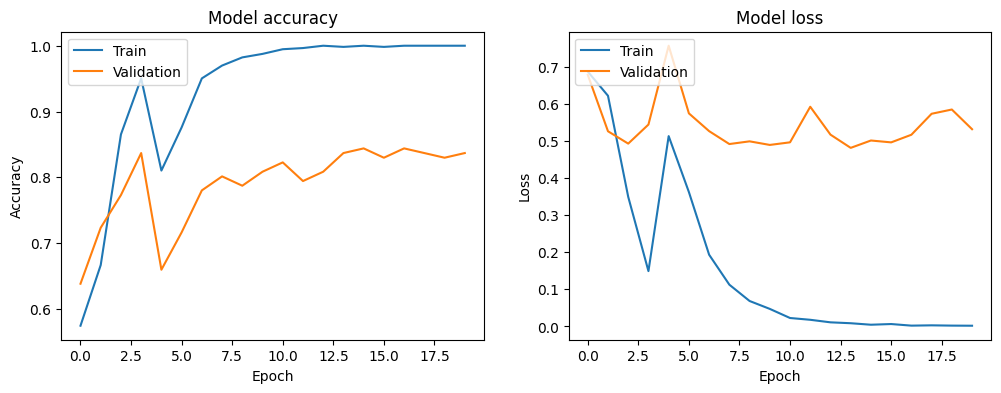

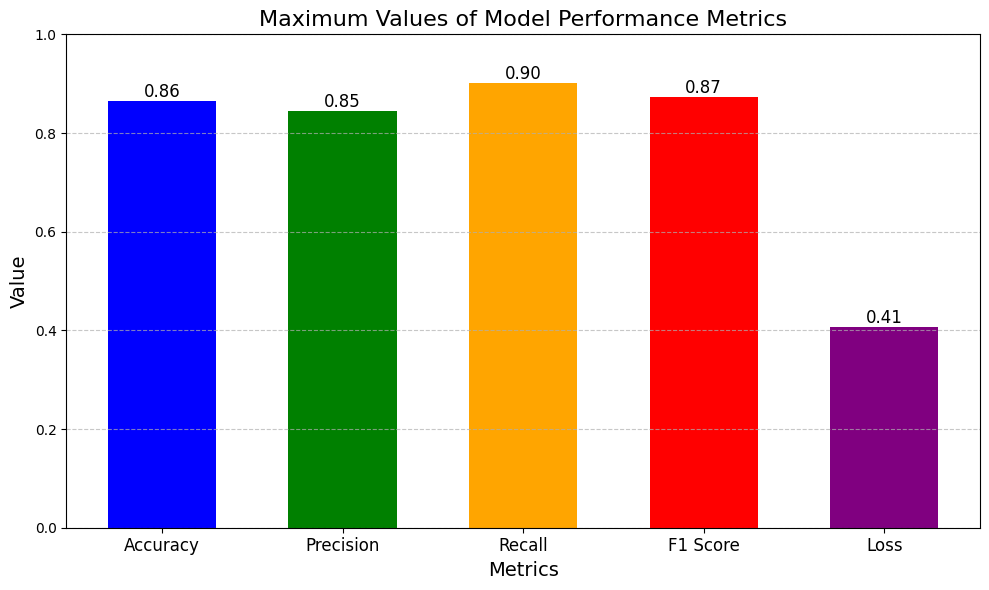

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the metrics
metrics = np.load('model_metrics.npy', allow_pickle=True).item()
history = np.load('training_history.npy', allow_pickle=True).item()

# Plotting the Training History
try:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()
except Exception as e:
    print(f"Error during plotting: {e}")

# Plot the maximum values of model performance metrics
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score", "Loss"]
max_values = [
    metrics['accuracy'],
    metrics['precision'],
    metrics['recall'],
    metrics['f1_score'],
    metrics['loss']
]

# Atur jarak antar bar
x = np.arange(len(metrics_names))  # Posisi x untuk setiap bar
bar_width = 0.6  # Lebar setiap bar

# Plot bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(x, max_values, color=["blue", "green", "orange", "red", "purple"], width=bar_width)

# Tambahkan nilai di atas setiap bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}", ha="center", va="bottom", fontsize=12)

# Tambahkan label dan judul
plt.title("Maximum Values of Model Performance Metrics", fontsize=16)
plt.ylabel("Value", fontsize=14)
plt.xlabel("Metrics", fontsize=14)
plt.xticks(x, metrics_names, fontsize=12)  # Posisi x diganti nama metrik
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim(0, 1)  # Tambahkan ruang di atas bar

# Tampilkan grafik
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Fungsi untuk memproses kalimat uji
def preprocess_text(text):
    # Proses yang sama seperti saat preprocessing data pelatihan
    text = str(text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Hapus karakter selain huruf dan spasi
    text = text.lower()  # Ubah teks menjadi lowercase
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Hapus stopwords
    return ' '.join(words)

# Fungsi untuk membuat vektor kalimat menggunakan tokenizer
def make_sentence_vector(sentence, tokenizer, max_len=100):
    # Preprocessing kalimat
    sentence = preprocess_text(sentence)

    # Ubah kalimat menjadi urutan angka berdasarkan tokenizer
    sequence = tokenizer.texts_to_sequences([sentence])

    # Padding agar panjangnya sesuai dengan max_len
    return pad_sequences(sequence, maxlen=max_len)

# Kalimat uji
test_sentence = "anjirrr lo cok"

# Membuat vektor kalimat uji
test_vec = make_sentence_vector(test_sentence, tokenizer, max_len=100)

# Periksa apakah vektor valid dan dapat diproses
if test_vec.shape[0] > 0:
    # Lakukan prediksi dengan model
    output = model.predict(test_vec)

    # Ambil prediksi yang dihasilkan (model output adalah probabilitas)
    prediction = 1 if output >= 0.5 else 0  # Ambil threshold 0.5 untuk keputusan
    sentiment = "Positive" if prediction == 1 else "Negative"

    print(f"Sentence: \"{test_sentence}\"")
    print(f"Predicted Sentiment: {sentiment}")
else:
    print("The test sentence contains words not in the vocabulary.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Sentence: "anjirrr lo cok"
Predicted Sentiment: Negative


## **Training 1020 Data**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-13-70759beb5902>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Label'] = df['Label'].astype(float)


Found NaN values in labels. Dropping rows with NaN values.


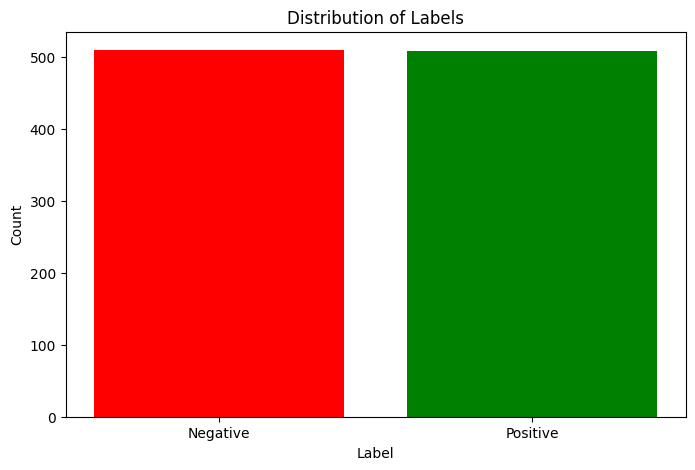

Label counts:
Label
0.0    510
1.0    509
Name: count, dtype: int64


In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/Dataset Analisis Sentimen (2).xlsx'
df = pd.read_excel(file_path)

# Data Preprocessing
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

def preprocess_text(text):
    text = str(text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['cleaned_text'] = df['Komentar'].apply(preprocess_text)

# Convert labels to numeric values
df['Label'] = df['Label'].map({'Negative': 0, 'Positive': 1})

# Check for NaN values in labels and handle them
if df['Label'].isnull().any():
    print("Found NaN values in labels. Dropping rows with NaN values.")
    df = df.dropna(subset=['Label'])

# Ensure labels are of type float32
df['Label'] = df['Label'].astype(float)

# Plotting the distribution of labels
label_counts = df['Label'].value_counts()
plt.figure(figsize=(8, 5))
plt.bar(label_counts.index, label_counts.values, color=['red', 'green'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

# Print the number of each label
print("Label counts:")
print(label_counts)

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import tensorflow as tf
import numpy as np

# Load the dataset
file_path = '/content/Dataset Analisis Sentimen (2).xlsx'
df = pd.read_excel(file_path)

# Data Preprocessing
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

def preprocess_text(text):
    text = str(text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['cleaned_text'] = df['Komentar'].apply(preprocess_text)

# Convert labels to numeric values
df['Label'] = df['Label'].map({'Negative': 0, 'Positive': 1})

# Check for NaN values in labels and handle them
if df['Label'].isnull().any():
    print("Found NaN values in labels. Dropping rows with NaN values.")
    df = df.dropna(subset=['Label'])

# Ensure labels are of type float32
df['Label'] = df['Label'].astype(np.float32)

# Tokenization and Padding
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

X = pad_sequences(sequences, maxlen=max_len)
y = df['Label'].values

# Ensure all data is numeric and of type float32
X = X.astype(np.float32)
y = y.astype(np.float32)

# Check for NaN or infinite values
if np.isnan(X).any() or np.isinf(X).any():
    raise ValueError("X contains NaN or infinite values")
if np.isnan(y).any() or np.isinf(y).any():
    raise ValueError("y contains NaN or infinite values")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define custom F1 Score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Initialize custom F1Score metric
f1_score_metric = F1Score()

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with built-in Precision, Recall, and the custom F1 Score
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        f1_score_metric
    ]
)

# Display the model summary
model.build(input_shape=(None, max_len))
model.summary()

# Train the model with additional debugging information
try:
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)
except Exception as e:
    print(f"Error during training: {e}")

# Evaluate the model on the test set
try:
    loss, accuracy, precision, recall, f1_score = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {accuracy}')
    print(f'Test Precision: {precision}')
    print(f'Test Recall: {recall}')
    print(f'Test F1 Score: {f1_score}')
except Exception as e:
    print(f"Error during evaluation: {e}")

# Save the metrics to a file
metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1_score,
    'loss': loss
}

np.save('model_metrics.npy', metrics)

# Save the training history
np.save('training_history.npy', history.history)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Found NaN values in labels. Dropping rows with NaN values.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 100, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,543,297 (5.89 MB)

 Trainable params: 1,543,297 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 494ms/step - accuracy: 0.5264 - f1_score: 0.6113 - loss: 0.6936 - precision_9: 0.5255 - recall_9: 0.7512 - val_accuracy: 0.6933 - val_f1_score: 0.7191 - val_loss: 0.6850 - val_precision_9: 0.6667 - val_recall_9: 0.7805
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.6969 - f1_score: 0.7376 - loss: 0.6693 - precision_9: 0.6645 - recall_9: 0.8360 - val_accuracy: 0.6380 - val_f1_score: 0.7204 - val_loss: 0.7113 - val_precision_9: 0.5891 - val_recall_9: 0.9268
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 587ms/step - accuracy: 0.7285 - f1_score: 0.7318 - loss: 0.5916 - precision_9: 0.7016 - recall_9: 0.7805 - val_accuracy: 0.6748 - val_f1_score: 0.7310 - val_loss: 0.6321 - val_precision_9: 0.6261 - val_recall_9: 0.8780
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 400ms/step - accuracy: 0.8288 - f1_score: 0.8491 - loss: 0.4636 - precision_9: 0.7539 - recall_9: 0.9751 - val_accuracy: 0.7546 - val_f1_score: 0.7590 - val_loss: 0.5256 - val

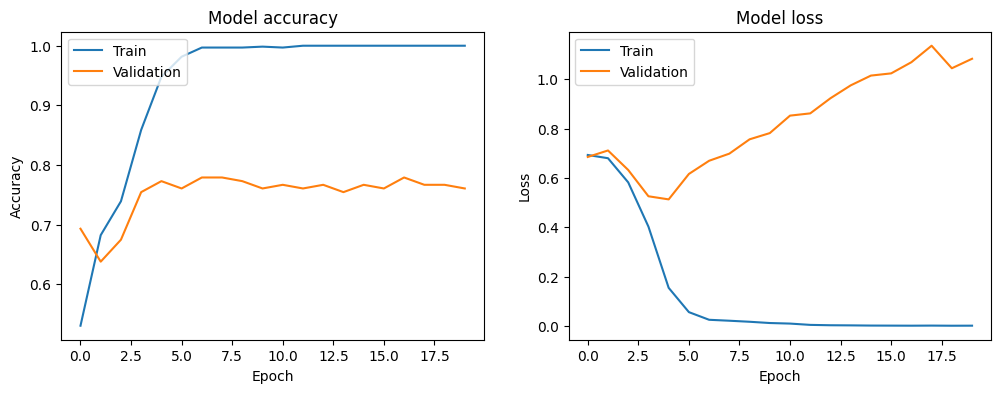

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the metrics
metrics = np.load('model_metrics.npy', allow_pickle=True).item()
history = np.load('training_history.npy', allow_pickle=True).item()

# Plotting the Training History
try:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()
except Exception as e:
    print(f"Error during plotting: {e}")


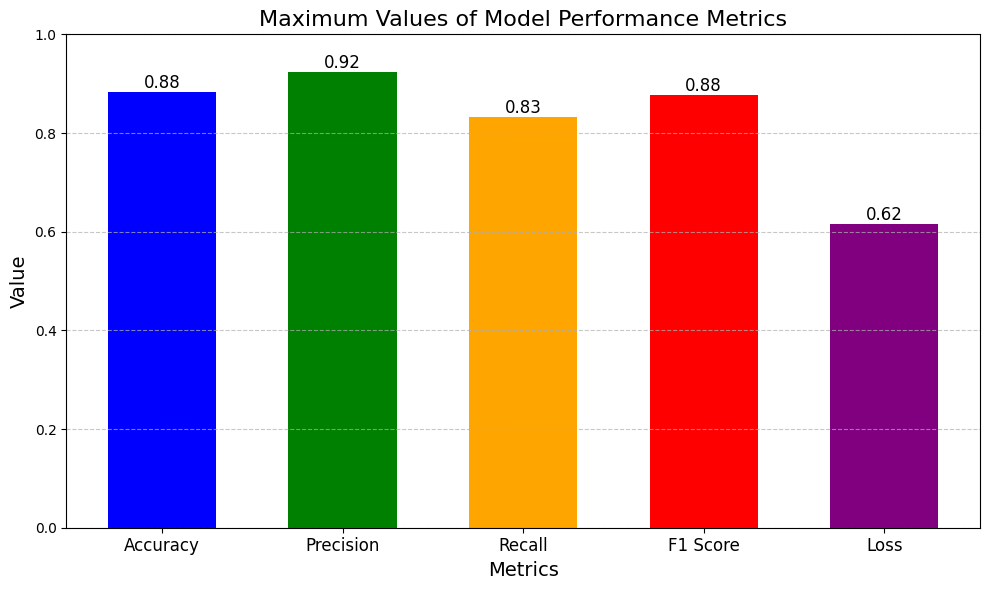

In [ ]:
# Plot the maximum values of model performance metrics
metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score", "Loss"]
max_values = [
    metrics['accuracy'],
    metrics['precision'],
    metrics['recall'],
    metrics['f1_score'],
    metrics['loss']
]

# Atur jarak antar bar
x = np.arange(len(metrics_names))  # Posisi x untuk setiap bar
bar_width = 0.6  # Lebar setiap bar

# Plot bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(x, max_values, color=["blue", "green", "orange", "red", "purple"], width=bar_width)

# Tambahkan nilai di atas setiap bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}", ha="center", va="bottom", fontsize=12)

# Tambahkan label dan judul
plt.title("Maximum Values of Model Performance Metrics", fontsize=16)
plt.ylabel("Value", fontsize=14)
plt.xlabel("Metrics", fontsize=14)
plt.xticks(x, metrics_names, fontsize=12)  # Posisi x diganti nama metrik
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim(0, 1)  # Tambahkan ruang di atas bar

# Tampilkan grafik
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Fungsi untuk memproses kalimat uji
def preprocess_text(text):
    # Proses yang sama seperti saat preprocessing data pelatihan
    text = str(text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Hapus karakter selain huruf dan spasi
    text = text.lower()  # Ubah teks menjadi lowercase
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Hapus stopwords
    return ' '.join(words)

# Fungsi untuk membuat vektor kalimat menggunakan tokenizer
def make_sentence_vector(sentence, tokenizer, max_len=100):
    # Preprocessing kalimat
    sentence = preprocess_text(sentence)

    # Ubah kalimat menjadi urutan angka berdasarkan tokenizer
    sequence = tokenizer.texts_to_sequences([sentence])

    # Padding agar panjangnya sesuai dengan max_len
    return pad_sequences(sequence, maxlen=max_len)

# Kalimat uji
test_sentence = "tolol banget lo cok"

# Membuat vektor kalimat uji
test_vec = make_sentence_vector(test_sentence, tokenizer, max_len=100)

# Periksa apakah vektor valid dan dapat diproses
if test_vec.shape[0] > 0:
    # Lakukan prediksi dengan model
    output = model.predict(test_vec)

    # Ambil prediksi yang dihasilkan (model output adalah probabilitas)
    prediction = 1 if output >= 0.5 else 0  # Ambil threshold 0.5 untuk keputusan
    sentiment = "Positive" if prediction == 1 else "Negative"

    print(f"Sentence: \"{test_sentence}\"")
    print(f"Predicted Sentiment: {sentiment}")
else:
    print("The test sentence contains words not in the vocabulary.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
Sentence: "tolol banget lo cok"
Predicted Sentiment: Negative
